# Olist data cleaning & preparation for Tableau

### Table of content

#### [1. Olist Table structure (original)](#0)
#### [2. Importing data from SQL- analysing & cleaning data using pandas](#1)
#### [3. Cleaning data in SQL](#2)
#### [4. Olist Table structure (cleaned)](#3)
#### [5. Joining data in SQL to increase Tableau performance](#4)


------

## 1. Olist Table structure (original)<a class="anchor" id="0"></a>


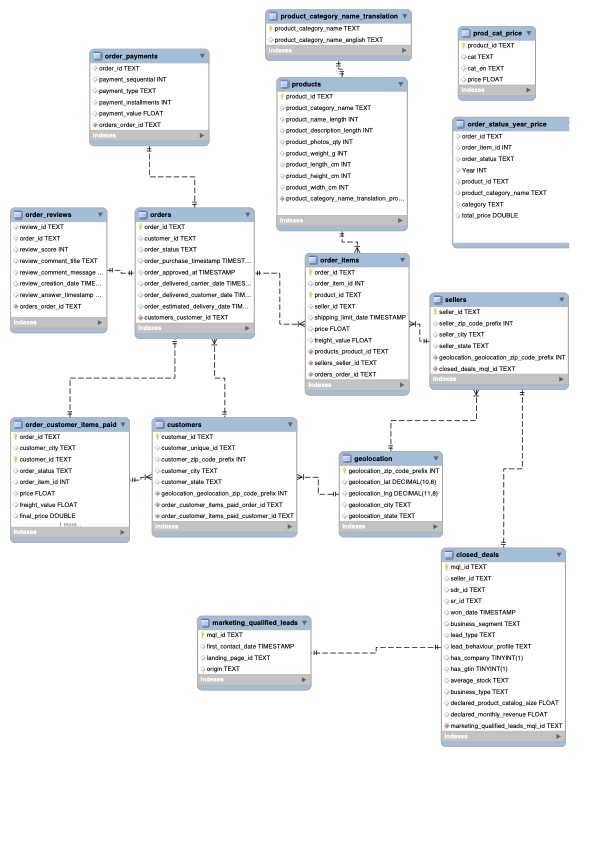

----

## 2. Importing SQL- analysing & cleaning data using pandas<a class="anchor" id="1"></a>

In [176]:
import pandas as pd
import getpass
import sqlalchemy as sa
import pymysql
from datetime import datetime,date




In [177]:

driver = 'mysql+pymysql'
user = 'root'
password = getpass.getpass(prompt='Your password:'"")
ip = '127.0.0.1'

connection_string = f'{driver}://{user}:{password}@{ip}'
    
db_connection = sa.create_engine(connection_string)

insp = sa.inspect(db_connection)
db_list = insp.get_schema_names()


Your password:········


### Check Olist tables concerning missing or misleading data

#### Closed_deals
Important to note : first data only from 2017-12-05

In [101]:
query = "SELECT * FROM olist.closed_deals"
closed_deals = pd.read_sql_query(query, db_connection)

In [102]:
##cleaning

def closed_deals_clean(closed_deals):
    #delete (no value added)
    closed_deals = closed_deals.drop(columns=['sdr_id'])
    closed_deals = closed_deals.drop(columns=['sr_id'])
    #delete (too many nulls)
    closed_deals = closed_deals.drop(columns=['lead_behaviour_profile'])
    closed_deals = closed_deals.drop(columns=['has_company'])
    closed_deals = closed_deals.drop(columns=['has_gtin'])
    closed_deals = closed_deals.drop(columns=['average_stock'])
    closed_deals = closed_deals.drop(columns=['declared_product_catalog_size'])
    #delete (too manny values = 0)
    closed_deals = closed_deals.drop(columns=['declared_monthly_revenue'])
    return closed_deals

closed_deals = closed_deals_clean(closed_deals)

closed_deals.isnull().sum()

##interesting to analyse
# time to close deal
# closed_deals per time (quarter/year)
# percentage buisness_segment and business_type


mql_id               0
seller_id            0
won_date             0
business_segment     1
lead_type            6
business_type       10
dtype: int64

In [103]:
# change datetime: removal of time in the timestemp to speed up calculations (date remains)
closed_deals['won_date'] = pd.to_datetime(closed_deals['won_date']).dt.date

In [104]:
#to push back to workbench:

closed_deals.to_sql(con=db_connection, schema='olist', name='closed_deals', if_exists='replace', index = False)

-----

#### Marketing_qualified_leads

In [105]:
query = "SELECT * FROM olist.marketing_qualified_leads"
marketing_qualified_leads = pd.read_sql_query(query, db_connection)
marketing_qualified_leads.isnull().sum()



## interesting (related to closed_deals)
# top 10 landing_page
# origin (also by time to close)

mql_id                 0
first_contact_date     0
landing_page_id        0
origin                60
dtype: int64

In [106]:
##cleaning
# null cells in origin into "unknown"
marketing_qualified_leads['origin'] = marketing_qualified_leads["origin"].fillna(value = 'unknown')
#marketing_qualified_leads.isnull().sum()

In [107]:
# change datetime: removal of time in the timestemp to speed up calculations (date remains)
marketing_qualified_leads['first_contact_date'] = pd.to_datetime(marketing_qualified_leads['first_contact_date']).dt.date

In [108]:
#to push back to workbench:

marketing_qualified_leads.to_sql(con=db_connection, schema='olist', name='marketing_qualified_leads', if_exists='replace', index = False)

-----

#### Sellers

In [178]:
query = "SELECT * FROM olist.`sellers`"
sellers = pd.read_sql_query(query, db_connection)
sellers.isnull().sum()


## interesting
#seller city
#seller state 

seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

In [110]:
##cleaning
#seller_city one has a number = rio de janeiro 04482255
sellers = sellers.replace(to_replace='04482255', value = 'rio de janeiro')
#tbd :seller state = full name

In [180]:
# add one more column to display the full state name
seller_state_name = sellers.seller_state

sellers.insert(loc=4,
          column='seller_state_name',
          value=seller_state_name)
sellers.head(2)

,seller_id,seller_zip_code_prefix,seller_city,seller_state,seller_state_name
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP,SP


In [181]:
#change abv. to full state name
def full_name(x):
    if not x == x:
        return x
    else:
        name = {'RO': 'Rondônia', 
'AC': 'Acre', 
'AM': 'Amazonas', 
'RR': 'Roraima', 
'PA': 'Pará', 
'AP': 'Amapá', 
'TO': 'Tocantins', 
'MA': 'Maranhão', 
'PI': 'Piauí', 
'CE': 'Ceará', 
'RN': 'Rio Grande do Norte', 
'PB': 'Paraíba', 
'PE': 'Pernambuco', 
'AL': 'Alagoas', 
'SE': 'Sergipe', 
'BA': 'Bahia', 
'MG': 'Minas Gerais', 
'ES': 'Espírito Santo', 
'RJ': 'Rio de Janeiro', 
'SP': 'Sao Paulo', 
'PR': 'Paraná', 
'SC': 'Santa Catarina', 
'RS': 'Rio Grande do Sul', 
'MS': 'Mato Grosso do Sul', 
'MT': 'Mato Grosso', 
'GO': 'Goiás', 
'DF': 'Distrito Federal'}
        return name[x]

In [182]:
#apply full_name function seller_state_name to full state name
sellers.seller_state_name = sellers.seller_state_name.apply(full_name)

In [184]:
#to push back to workbench:

sellers.to_sql(con=db_connection, schema='olist', name='sellers', if_exists='replace', index = False)

-----

#### Orders

In [112]:
query = "SELECT * FROM olist.orders"
orders = pd.read_sql_query(query, db_connection)
orders.isnull().sum()


##interesting
# percentage order status 
# actual vs esimated delivery date (only orders who have a order_delivered_customer_date)

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

In [113]:
# change datetime: removal of time in the timestemp to speed up calculations (date remains)
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp']).dt.date
orders['order_approved_at'] = pd.to_datetime(orders['order_approved_at']).dt.date
orders['order_delivered_carrier_date'] = pd.to_datetime(orders['order_delivered_carrier_date']).dt.date
orders['order_delivered_customer_date'] = pd.to_datetime(orders['order_delivered_customer_date']).dt.date
orders['order_estimated_delivery_date'] = pd.to_datetime(orders['order_estimated_delivery_date']).dt.date

In [114]:
##cleaning
#bucketing "processing & approved, invoiced"  as these orders have not been processed correctly: new name "unprocessed"; rename "shipped" "lost_during_delivery"

orders.order_status[orders.order_status.isin(["processing","invoiced", "approved"])] = "unprocessed"
orders.order_status[orders.order_status.isin(["shipped"])] = "lost_during_delivery"
orders.order_status.unique()

## data from september 2018 not complete, therfore we will delete this month in sql


array(['delivered', 'unprocessed', 'lost_during_delivery', 'unavailable',
       'canceled', 'created'], dtype=object)

In [115]:
#to push back to workbench:

orders.to_sql(con=db_connection, schema='olist', name='orders', if_exists='replace',index = False)

-----

#### Order_items

In [116]:
query = "SELECT * FROM olist.order_items"
order_items = pd.read_sql_query(query, db_connection)
order_items.isnull().sum()

## findings
# freight_value & price & final_price are the prices for the customer (and is the same as in other tables)
# order_item_id has  21 uniques -->  shows how many items are included in one order shipped out to the customer
# shipping_limit_date = latest time when the seller has to give the product to the carrier for delivery

##interesting
#which seller violate the shipping_limit_date (shipping_date_limit<order_delivered_carrier_date)

order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

In [117]:
# change datetime: removal of time in the timestemp to speed up calculations (date remains)
order_items['shipping_limit_date'] = pd.to_datetime(order_items['shipping_limit_date']).dt.date


In [118]:
#to push back to workbench:

order_items.to_sql(con=db_connection, schema='olist', name='order_items', if_exists='replace',index = False)

-----

#### Order_payments

In [119]:
query = "SELECT * FROM olist.order_payments"
order_payments = pd.read_sql_query(query, db_connection)
order_payments.isnull().sum()


## Interesting
#percentage of payment_type per month /year (reference order_delivered_customer_date)
#payment_installments: average payment_installments, zip_code analysis, category analysis

order_id                0
payment_sequential      0
payment_type            0
payment_installments    0
payment_value           0
dtype: int64

In [120]:
## cleanining
#payment_type = delete rows where type = 'not_defined' as payment value of these three order = 0€
#we will delete these rows in sql


#payment_sequential = no clear added value
order_payments = order_payments.drop(columns=['payment_sequential'])

In [121]:
#to push back to workbench:

order_payments.to_sql(con=db_connection, schema='olist', name='order_payments', if_exists='replace', index = False)

-----

#### Customers

In [164]:
query = "SELECT * FROM olist.customers"
customers = pd.read_sql_query(query, db_connection)
customers.isnull().sum()

##cleaning
#tbd customer state = full name

## interesting
#customer city
#customer state 

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

In [165]:
# add one more column to display the full state name
customer_state_name = customers.customer_state

In [166]:
customers.insert(loc=5,
          column='customer_state_name',
          value=customer_state_name)
customers.head(2)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,customer_state_name
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,SP


In [168]:
#apply full_name function customer_state_name to full state name
customers.customer_state_name = customers.customer_state_name.apply(full_name)

In [170]:
#to push back to workbench:

customers.to_sql(con=db_connection, schema='olist', name='customers', if_exists='replace', index = False)

-----

#### Customer_items_paid

In [53]:
query = "SELECT * FROM olist.`order_customer_items_paid`"
order_customer_items_paid = pd.read_sql_query(query, db_connection)
order_customer_items_paid.isnull().sum()

##
#how many delivered orders haven't been paid yet (compare with order_ids in orders where status is 'delivered'): no one (checked in Sql)


##Interesting
#show percentage odrder_status (if order_status = "shipping" / "lost_during_delivery" --> order paid but not received)

order_id         0
customer_city    0
customer_id      0
order_status     0
order_item_id    0
price            0
freight_value    0
final_price      0
dtype: int64

----

#### Order_reviews

In [122]:
query = "SELECT * FROM olist.order_reviews"
order_reviews = pd.read_sql_query(query, db_connection)
order_reviews.isnull().sum()

## interesting
# review_score
# top 10 seller score / low 10 seller score compare to their revenue per month/year 
# review answer velocity over time(month/year) (calculated review_answer_timestamp-review_creation_date)
# from which region come the most reviews / also by good and bad score

review_id                      0
order_id                       0
review_score                   0
review_comment_title       88285
review_comment_message     58245
review_creation_date           0
review_answer_timestamp        0
dtype: int64

In [123]:
# change datetime: removal of time in the timestemp to speed up calculations (date remains)
order_reviews['review_creation_date'] = pd.to_datetime(order_reviews['review_creation_date']).dt.date
order_reviews['review_answer_timestamp'] = pd.to_datetime(order_reviews['review_answer_timestamp']).dt.date

In [124]:
#to push back to workbench:

order_reviews.to_sql(con=db_connection, schema='olist', name='order_reviews', if_exists='replace', index = False)

-----

#### Order_status_year_price

In [125]:
query = "SELECT * FROM olist.`order_status_year_price`"
order_status_year_price = pd.read_sql_query(query, db_connection)
order_status_year_price.isnull().sum()
##findings
#only delivered 
# Year referres to the order_purchase_timestamp from orders
# no additional information to order_customer_items_paid

##cleaning
#we will drop this table in sql




order_id                 0
order_item_id            0
order_status             0
Year                     0
product_id               0
product_category_name    0
category                 0
total_price              0
dtype: int64

-----

#### Products

In [126]:
query = "SELECT * FROM olist.`products`"
products = pd.read_sql_query(query, db_connection)
products.isnull().sum()


##interesting
# which seller haven't provided all of the necessary information 



product_id                      0
product_category_name         610
product_name_length           610
product_description_length    610
product_photos_qty            610
product_weight_g                6
product_length_cm               2
product_height_cm               2
product_width_cm                2
dtype: int64

In [127]:
##cleaning
# drop null values as they are won't give any value in answering the most bought categories
products =products.dropna()

#change product_catgeory_name to english

def change_name(x):
    if not x == x:
        return x
    else:
        category = {"beleza_saude": "health_beauty",
        "informatica_acessorios":"computers_accessories",
        "automotivo":"auto",
        "cama_mesa_banho":"bed_bath_table",
        "moveis_decoracao":"furniture_decor",
        "esporte_lazer":"sports_leisure",
        "perfumaria":"perfumery",
        "utilidades_domesticas":"housewares",
        "telefonia":"telephony",
        "relogios_presentes":"watches_gifts",
        "alimentos_bebidas":"food_drink",
        "bebes":"baby",
        "papelaria":"stationery",
        "tablets_impressao_imagem":"tablets_printing_image",
        "brinquedos":"toys",
        "telefonia_fixa":"fixed_telephony",
        "ferramentas_jardim":"garden_tools",
        "fashion_bolsas_e_acessorios":"fashion_bags_accessories",
        "eletroportateis":"small_appliances",
        "consoles_games":"consoles_games",
        "audio":"audio",
        "fashion_calcados":"fashion_shoes",
        "cool_stuff":"cool_stuff",
        "malas_acessorios":"luggage_accessories",
        "climatizacao":"air_conditioning",
        "construcao_ferramentas_construcao":"construction_tools_construction",
        "moveis_cozinha_area_de_servico_jantar_e_jardim":"kitchen_dining_laundry_garden_furniture",
        "construcao_ferramentas_jardim":"costruction_tools_garden",
        "fashion_roupa_masculina":"fashion_male_clothing",
        "pet_shop":"pet_shop",
        "moveis_escritorio":"office_furniture",
        "market_place":"market_place",
        "eletronicos":"electronics",
        "eletrodomesticos":"home_appliances",
        "artigos_de_festas":"party_supplies",
        "casa_conforto":"home_confort",
        "construcao_ferramentas_ferramentas":"costruction_tools_tools",
        "agro_industria_e_comercio":"agro_industry_and_commerce",
        "moveis_colchao_e_estofado":"furniture_mattress_and_upholstery",
        "livros_tecnicos":"books_technical",
        "casa_construcao":"home_construction",
        "instrumentos_musicais":"musical_instruments",
        "moveis_sala":"furniture_living_room",
        "construcao_ferramentas_iluminacao":"construction_tools_lights",
        "industria_comercio_e_negocios":"industry_commerce_and_business",
        "alimentos":"food",
        "artes":"art",
        "moveis_quarto":"furniture_bedroom",
        "livros_interesse_geral":"books_general_interest",
        "construcao_ferramentas_seguranca":"construction_tools_safety",
        "fashion_underwear_e_moda_praia":"fashion_underwear_beach",
        "fashion_esporte":"fashion_sport",
        "sinalizacao_e_seguranca":"signaling_and_security",
        "pcs":"computers",
        "artigos_de_natal":"christmas_supplies",
        "fashion_roupa_feminina":"fashio_female_clothing",
        "eletrodomesticos_2":"home_appliances_2",
        "livros_importados":"books_imported",
        "bebidas":"drinks",
        "cine_foto":"cine_photo",
        "la_cuisine":"la_cuisine",
        "musica":"music",
        "casa_conforto_2":"home_comfort_2",
        "portateis_casa_forno_e_cafe":"small_appliances_home_oven_and_coffee",
        "cds_dvds_musicais":"cds_dvds_musicals",
        "dvds_blu_ray":"dvds_blu_ray",
        "flores":"flowers",
        "artes_e_artesanato":"arts_and_craftmanship",
        "fraldas_higiene":"diapers_and_hygiene",
        "fashion_roupa_infanto_juvenil":"fashion_childrens_clothes",
        "seguros_e_servicos":"security_and_services",
         "pc_gamer":"pc_gamer", 
         "portateis_cozinha_e_preparadores_de_alimentos":"kitchen_appliance"}

        return category[x]
    


In [128]:
products["product_category_name"] = products["product_category_name"].apply(change_name)


In [129]:
products["product_category_name"].unique()

array(['perfumery', 'art', 'sports_leisure', 'baby', 'housewares',
       'musical_instruments', 'cool_stuff', 'furniture_decor',
       'home_appliances', 'toys', 'bed_bath_table',
       'construction_tools_safety', 'computers_accessories',
       'health_beauty', 'luggage_accessories', 'garden_tools',
       'office_furniture', 'auto', 'electronics', 'fashion_shoes',
       'telephony', 'stationery', 'fashion_bags_accessories', 'computers',
       'home_construction', 'watches_gifts',
       'construction_tools_construction', 'pet_shop', 'small_appliances',
       'agro_industry_and_commerce', 'furniture_living_room',
       'signaling_and_security', 'air_conditioning', 'consoles_games',
       'books_general_interest', 'costruction_tools_tools',
       'fashion_underwear_beach', 'fashion_male_clothing',
       'kitchen_dining_laundry_garden_furniture',
       'industry_commerce_and_business', 'fixed_telephony',
       'construction_tools_lights', 'books_technical',
       'home_app

In [131]:
#bucketing of the categories: from 73 to 21 buckets
products.product_category_name[products.product_category_name.isin(['christmas_supplies','cool_stuff','party_supplies'])] = "event_supplies"
products.product_category_name[products.product_category_name.isin(['bed_bath_table','furniture_bedroom','furniture_decor','furniture_living_room', 'furniture_mattress_and_upholstery', 'kitchen_dining_laundry_garden_furniture'])] = "furniture"
products.product_category_name[products.product_category_name.isin(['art','arts_and_craftmanship'])] = "arts"  
products.product_category_name[products.product_category_name.isin(['books_general_interest','books_imported', 'books_technical'])] = "books" 
products.product_category_name[products.product_category_name.isin(['cds_dvds_musicals','dvds_blu_ray','audio','music','musical_instruments'])] = "video_audio_instruments"  
products.product_category_name[products.product_category_name.isin(['electronics', 'computers','computers_accessories','fixed_telephony','cine_photo','telephony'])] = "electronics"      
products.product_category_name[products.product_category_name.isin(['construction_tools_lights', 'construction_tools_safety', 'costruction_tools_garden','costruction_tools_tools','construction_tools_construction','home_construction'])] = "construction_tools"                                
products.product_category_name[products.product_category_name.isin(['fashio_female_clothing','fashion_bags_accessories','fashion_childrens_clothes','fashion_male_clothing','fashion_shoes','fashion_underwear_beach','luggage_accessories'])] = "fashion"   
products.product_category_name[products.product_category_name.isin(['baby','diapers_and_hygiene'])] = "baby"                                 
products.product_category_name[products.product_category_name.isin(['food','food_drink','drinks'])] = "food_drinks"                                                                 
products.product_category_name[products.product_category_name.isin(["kitchen_appliance", "small_appliances_home_oven_and_coffee", "la_cuisine"])] = "kitchen"
products.product_category_name[products.product_category_name.isin(["perfumery", "health_beauty"])] = "health_beauty"
products.product_category_name[products.product_category_name.isin(["security_and_services", "signaling_and_security"])] = "security"
products.product_category_name[products.product_category_name.isin(["flowers", "garden_tools", "agro_industry_and_commerce"])] = "garden"
products.product_category_name[products.product_category_name.isin(['pet_shop'])] = "pets"
products.product_category_name[products.product_category_name.isin(["office_furniture", "industry_commerce_and_business", "stationery", "tablets_printing_image"])] = "office"
products.product_category_name[products.product_category_name.isin(["pc_gamer", "consoles_games", "toys"])] = "games"
products.product_category_name[products.product_category_name.isin(["small_appliances", "home_appliances", "home_appliances_2", "home_comfort_2", "home_confort", "housewares", "air_conditioning"])] = "home_appliances"                               
products.product_category_name[products.product_category_name.isin(['watches_gifts'])] = "watches"  
products.product_category_name[products.product_category_name.isin(['fashion_sport','sports_leisure'])] = "sports"
                               

<ipython-input-131-580354d46112>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  products.product_category_name[products.product_category_name.isin(['christmas_supplies','cool_stuff','party_supplies'])] = "event_supplies"
<ipython-input-131-580354d46112>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  products.product_category_name[products.product_category_name.isin(['bed_bath_table','furniture_bedroom','furniture_decor','furniture_living_room', 'furniture_mattress_and_upholstery', 'kitchen_dining_laundry_garden_furniture'])] = "furniture"
<ipython-input-131-580354d46112>:4: SettingWithCopyWarning: 
A value is tryin

In [133]:
products["product_category_name"].unique()

array(['health_beauty', 'arts', 'sports', 'baby', 'home_appliances',
       'video_audio_instruments', 'event_supplies', 'furniture', 'games',
       'construction_tools', 'electronics', 'fashion', 'garden', 'office',
       'auto', 'watches', 'pets', 'security', 'books', 'food_drinks',
       'market_place', 'kitchen'], dtype=object)

In [134]:
#to push back to workbench:

products.to_sql(con=db_connection, schema='olist', name='products', if_exists='replace', index = False)

-----

#### Product_category_name_translation

In [64]:
query = "SELECT * FROM olist.`product_category_name_translation`"
product_category_name_translation = pd.read_sql_query(query, db_connection)
product_category_name_translation.isnull().sum()

##cleaning
# just needed to translate we will drop table in sql



product_category_name            0
product_category_name_english    0
dtype: int64

-----

#### Geolocation

In [34]:
query = "SELECT * FROM olist.geolocation"
geolocation = pd.read_sql_query(query, db_connection)
geolocation.isnull().sum()

# we don't need this table as we are using tableau and it can create lattitude itself with the city information
#we will drop table in sql

geolocation_zip_code_prefix    0
geolocation_lat                0
geolocation_lng                0
geolocation_city               0
geolocation_state              0
dtype: int64

------

## 3. Cleaning data in SQL<a class="anchor" id="2"></a>

In [175]:
#### Drop not needed table

#drop table `order_status_year_price`
#drop table `prod_cat_price`
#drop table `product_category_name_translation`
#drop table `geolocation`

## Delete rows without value 

#in payment_type: delete rows where type = 'not_defined' as payment value of these three order = 0€
#delete from olist.order_payments where order_id in ('4637ca194b6387e2d538dc89b124b0ee','00b1cb0320190ca0daa2c88b35206009','c8c528189310eaa44a745b8d9d26908b')

# in order_customer_items_paid delete rows with status "shipped" --> we have analysed that these order has been lost during delivery and most likely the customer git a refund
# delete from order_customer_items_paid where order_status in ('shipped')

## data from september 2018 not complete, therfore we will delete this month
# delete from orders where order_purchase_timestamp > "2018-09-01";


-----

## 4. Olist Table structure (cleaned)<a class="anchor" id="3"></a>

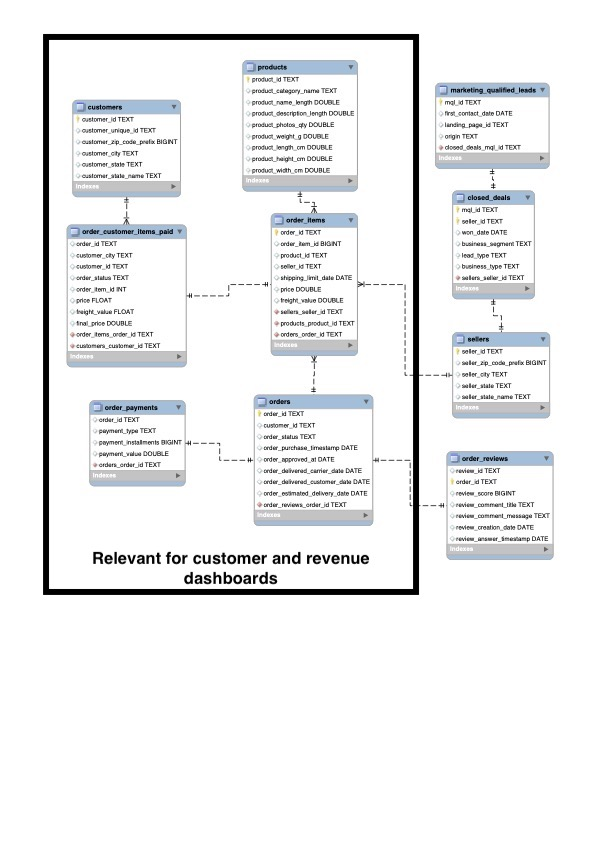

-----

## 5. Joining data in SQL to increase Tableau performance<a class="anchor" id="4"></a>
To speed up the performance in tableau we will join the needed tables/columns in SQL and then use that table for viszualitation in Tableau


#### Revenue_customer dashboard

In [174]:
# Create table revenue_category
# SELECT `orders`.`order_status`, `orders`.`order_purchase_timestamp`, `orders`.`order_approved_at`, `orders`.`order_delivered_carrier_date`, `orders`.`order_delivered_customer_date`, `orders`.`order_estimated_delivery_date`, `order_customer_items_paid`.`order_id`,
#    `order_customer_items_paid`.`customer_city`,
#    `order_customer_items_paid`.`customer_id`,
#    `order_customer_items_paid`.`order_item_id`,
#    `order_customer_items_paid`.`price`,
#   `order_customer_items_paid`.`freight_value`,
#    `order_customer_items_paid`.`final_price`,
#    `customers`.`customer_zip_code_prefix`,
#    `customers`.`customer_state`,
#    `products`.`product_category_name`,
#    `order_payments`.`payment_installments`,
#    `order_payments`.`payment_type`,
#    `customers`.`customer_state_name`,
#    `order_items`.`seller_id`
# FROM olist.orders
# inner join `order_customer_items_paid`
# using (order_id)
# inner join customers
# on `customers`.`customer_id` = `orders`.`customer_id`
# inner join order_items
# on `order_items`.`order_id` = `order_customer_items_paid`.`order_id`
# inner join products
# on `products`.`product_id` = `order_items`.`product_id`
# inner join order_payments
# on `order_payments`.`order_id` = `order_customer_items_paid`.`order_id`;

-----